<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/GravityResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install "git+https://github.com/Karasiari/graphmcf.git"

  Cloning https://github.com/Karasiari/graphmcf.git to /tmp/pip-req-build-jjagb5n4
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcf.git /tmp/pip-req-build-jjagb5n4
  Resolved https://github.com/Karasiari/graphmcf.git to commit 1fd1e779139c269c68e00b95fe9b6dafa0e82e9c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcf: filename=graphmcf-0.1.0-py3-none-any.whl size=46766 sha256=e2ad7abc9c32ebcff4f4c7258afdaaf0725a4fa2eebacb8d586ee04d89693ed6
  Stored in directory: /tmp/pip-ephem-wheel-cache-fqfc4jq8/wheels/e2/0b/c2/f959f38e6d22c15057366b9e17b9295eb9dfc85fd11eff7962
Successfully built graphmcf


In [2]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности взвешенного графа - веса capacity,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  #df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    #adj_matrix[new_source, new_target] = length
    #adj_matrix[new_target, new_source] = length
    adj_matrix[new_source, new_target] = capacity_value
    adj_matrix[new_target, new_source] = capacity_value

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь

In [3]:
import numpy as np

import cvxpy as cp
import networkx as nx

from dataclasses import dataclass
from typing import Optional

@dataclass(frozen=True)
class Solution:
    problem: cp.Problem
    flow: np.ndarray
    add_bandwidth: Optional[np.ndarray] = None
    gamma: Optional[float] = None
    traffic_mat: Optional[float] = None

    def to_vector(self) -> np.ndarray:
        sol_parts = [self.flow.T.flatten()]
        if self.add_bandwidth is not None:
            sol_parts.append(self.add_bandwidth)
        if self.gamma is not None:
            sol_parts.append(self.gamma)
        return np.hstack(sol_parts)


def vector_to_solution(graph: nx.DiGraph, vec: np.ndarray, problem_type: str):
    m, n = graph.number_of_edges(), graph.number_of_nodes()
    flow = vec[: m * n].reshape(n, m).T
    add_bandwidth = None
    gamma = None
    if problem_type in ["opt_network_min_cost_concurrent_flow", "opt_network_max_concurrent_flow"]:
        add_bandwidth = vec[m * n : m * n + m]
    if problem_type in ["max_concurrent_flow", "opt_network_max_concurrent_flow"]:
        gamma = vec[-1]
    return Solution(problem=None, flow=flow, add_bandwidth=add_bandwidth, gamma=gamma)

# Вспомогательные

def get_incidence_matrix(graph: nx.DiGraph) -> np.ndarray:
    """
    Construct incidence matrix
    :param graph: nx.DiGraph,: graph with attribute cost on edges
    :return:
        incidence_matrix: ndarray of shape (num_nodes, num_edges), incidence matrix
    """
    incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)
    incidence_matrix = incidence_matrix.toarray()
    return incidence_matrix

def get_weights(graph: nx.DiGraph) -> np.ndarray:
    """
    Extract edge weights
    :param graph: nx.DiGraph, graph with weights on edges
    :param key: str, name of attribute to obtain weights
    :return:
        weights: ndarray of shape (num_nodes), all edge weights in graph
    """
    edges_with_weights = [(edge, data['weight']) for edge, data in graph.edges.items()]
    edges_with_weights_dict = {key: value for key, value in edges_with_weights}
    return np.array(list(edges_with_weights_dict.values()), dtype=np.float64)

def get_var_value(var: Optional[cp.Variable]) -> Optional[float | np.ndarray]:
    """
    Get cvxpy.Variable value if not None
    :param var: cvxpy.Variable, variable to extract value
    :return:
        value: var.value if var is not None, else None
    """
    return var.value if var is not None else None


# Решение

def solve_throughput(graph: nx.Graph, traffic_lapl: np.ndarray, **solver_kwargs) -> Solution:
    graph = nx.DiGraph(graph)
    incidence_mat = get_incidence_matrix(graph)
    bandwidth = get_weights(graph)

    flow = cp.Variable((len(graph.edges), traffic_lapl.shape[0]))
    gamma = cp.Variable()
    prob = cp.Problem(
        cp.Maximize(gamma),
        [cp.sum(flow, axis=1) <= bandwidth, incidence_mat @ flow == -gamma * traffic_lapl.T, flow >= 0, gamma >= 0],
    )
    prob.solve(**solver_kwargs)

    if prob.status != "optimal":
        gamma = None

    return Solution(problem=prob, flow=get_var_value(flow), gamma=get_var_value(gamma))

In [4]:
small_graphs_for_test_names = ['cola_t2']
small_graphs_for_test = get_graphs(path_to_folder, small_graphs_for_test_names, True)

/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])


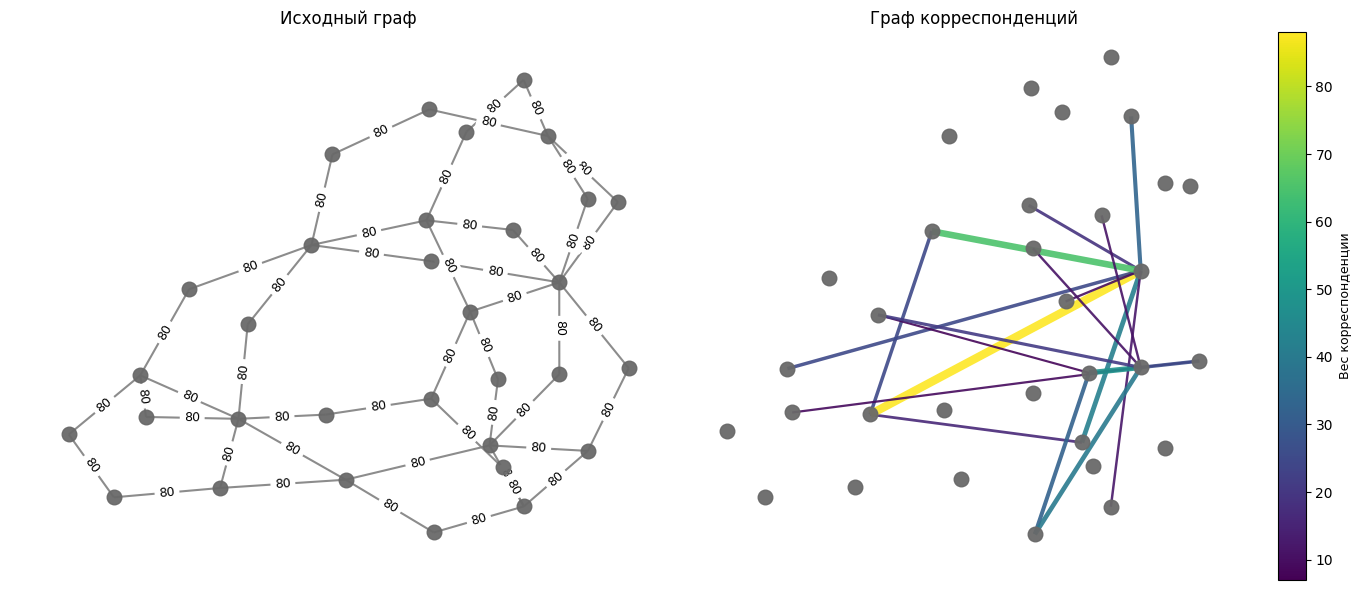

In [19]:
import numpy as np
from graphmcf.core import GraphMCF
from graphmcf.demands import GravitationalGenerator

for name, graph in small_graphs_for_test.items():
  graph_gravity = GraphMCF(graph['adj_matrix'])
  gen = GravitationalGenerator(beta=0.4, intensity=3*80*26, centrality='pagerank', edge_perc=1/26, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=0.8)
  res = gen.generate(graph_gravity)
  graph_gravity.visualise_with_demands()

In [6]:
from graphmcf.data import compute_laplacian_matrix

betas_batch = [0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15]
iter_stats = 2
output_for_stats = []
for i in range(iter_stats):
  for name, graph in small_graphs_for_test.items():
    betas_gamma = []
    betas_workload = []
    for beta in betas_batch:
      graph_gravity = GraphMCF(graph['adj_matrix'])
      gen = GravitationalGenerator(beta=beta, intensity=3*80*26, centrality='pagerank', edge_perc=1/26, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=0.8)
      res = gen.generate(graph_gravity)
      demands_laplacian = compute_laplacian_matrix(graph_gravity.demands_graph)

      sol = solve_throughput(graph_gravity.graph, demands_laplacian)
      gamma = sol.gamma
      betas_gamma.append(f"beta={beta}: {gamma:.3f}")
      output_for_stats.append((beta, gamma))

      demands_sum = sum(data['weight'] for u, v, data in graph_gravity.demands_graph.edges(data=True))
      capacity_sum = sum(data['weight'] for u, v, data in graph_gravity.graph.edges(data=True))
      workload = demands_sum / capacity_sum
      betas_workload.append(f"beta={beta}: {workload:.3f}")

    gamma_sequence = " ".join(betas_gamma)
    workload_sequence = " ".join(betas_workload)
    print(f"\n\nРешение MCF на итоге:\nЗначения gamma: {gamma_sequence}\nСредняя загруженность ребер: {workload_sequence}\n\n")



Решение MCF на итоге:
Значения gamma: beta=0.85: 0.462 beta=0.8: 0.503 beta=0.75: 0.599 beta=0.7: 0.567 beta=0.65: 0.623 beta=0.6: 0.667 beta=0.55: 0.777 beta=0.5: 0.808 beta=0.45: 0.941 beta=0.4: 1.096 beta=0.35: 1.103 beta=0.3: 1.308 beta=0.25: 1.253 beta=0.2: 1.253 beta=0.15: 1.258
Средняя загруженность ребер: beta=0.85: 0.139 beta=0.8: 0.135 beta=0.75: 0.128 beta=0.7: 0.138 beta=0.65: 0.134 beta=0.6: 0.140 beta=0.55: 0.132 beta=0.5: 0.144 beta=0.45: 0.132 beta=0.4: 0.140 beta=0.35: 0.137 beta=0.3: 0.134 beta=0.25: 0.136 beta=0.2: 0.140 beta=0.15: 0.137




Решение MCF на итоге:
Значения gamma: beta=0.85: 0.449 beta=0.8: 0.508 beta=0.75: 0.552 beta=0.7: 0.565 beta=0.65: 0.599 beta=0.6: 0.667 beta=0.55: 0.769 beta=0.5: 0.796 beta=0.45: 0.860 beta=0.4: 1.026 beta=0.35: 1.135 beta=0.3: 1.223 beta=0.25: 1.273 beta=0.2: 1.215 beta=0.15: 1.256
Средняя загруженность ребер: beta=0.85: 0.143 beta=0.8: 0.136 beta=0.75: 0.135 beta=0.7: 0.139 beta=0.65: 0.144 beta=0.6: 0.138 beta=0.55: 0.136 

In [7]:
from scipy.stats import pearsonr

x, y = [], []
for i, j in output_for_stats:
  x.append(i)
  y.append(float(j))

corr_coef, p_value = pearsonr(x, y)
alpha = 0.05
is_significant = p_value < alpha

print(f"Коэффициент корреляции: {corr_coef:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Результат значим при alpha={alpha}: {is_significant}")

Коэффициент корреляции: -0.9760
P-value: 0.0000
Результат значим при alpha=0.05: True


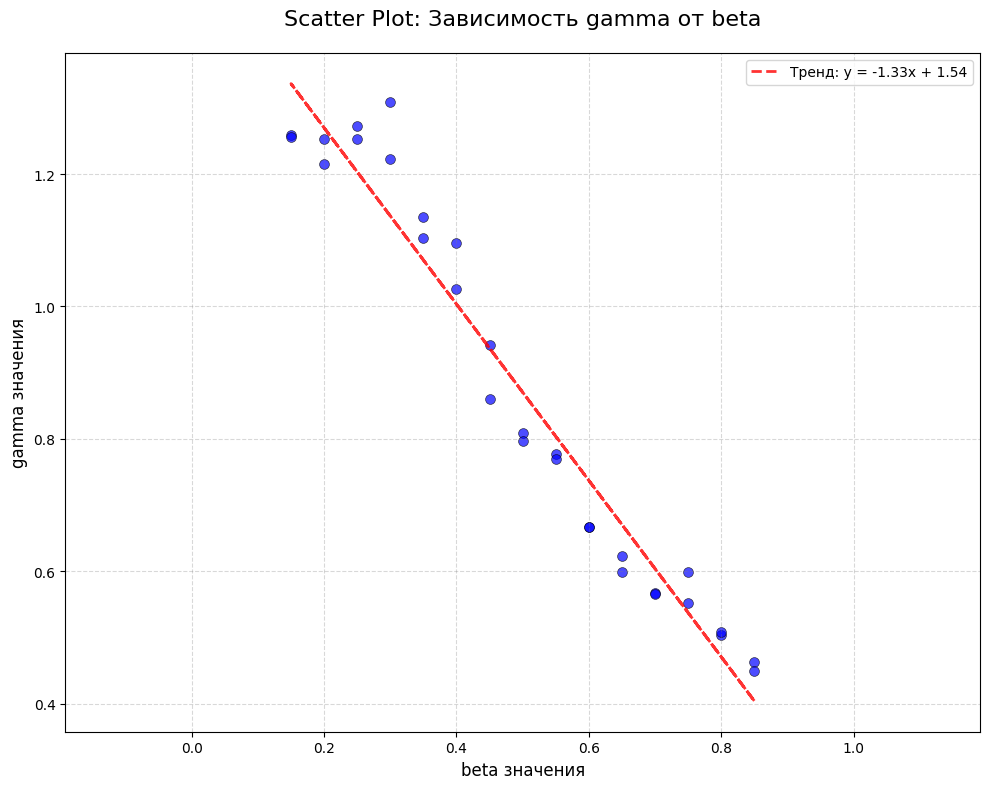

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # размер графика (ширина, высота)

# Основной scatter plot
scatter = plt.scatter(
    x, y,                    # данные
    c='blue',                # цвет точек
    alpha=0.7,               # прозрачность (0-1)
    s=50,                    # размер точек
    edgecolors='black',      # цвет границ
    linewidths=0.5,          # толщина границ
    marker='o'               # форма точек ('o', 's', '^', 'D', etc.)
)

# 3. Настройка внешнего вида
plt.title('Scatter Plot: Зависимость gamma от beta', fontsize=16, pad=20)
plt.xlabel('beta значения', fontsize=12)
plt.ylabel('gamma значения', fontsize=12)

# Сетка
plt.grid(True, linestyle='--', alpha=0.3, color='gray')

# Линия тренда (опционально)
z = np.polyfit(x, y, 1)  # линейная регрессия
p = np.poly1d(z)
plt.plot(x, p(x), "r--", alpha=0.8, linewidth=2, label=f'Тренд: y = {z[0]:.2f}x + {z[1]:.2f}')

# 4. Легенда
plt.legend(fontsize=10)

# 5. Равный масштаб осей (если нужно)
plt.axis('equal')

# 6. Показать график
plt.tight_layout()
plt.show()

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def analyze_sample(x, y, z, name, ax1, ax2, color1='red', color2='blue'):
    x_array = np.array(x, dtype=float)
    y_array = np.array(y, dtype=float)
    z_array = np.array(z, dtype=float)

    corr_coef, p_value = pearsonr(x_array, y_array)

    significance = "значим" if p_value < 0.05 else "не значим"
    print(f"{name} (beta, gamma): Корреляция = {corr_coef:.4f}, p-value = {p_value:.4f} ({significance})")

    # Сводка по z
    z_min = np.min(z_array)
    z_max = np.max(z_array)
    z_range = z_max - z_min  # Разница между максимумом и минимумом
    z_std = np.std(z_array)
    z_mean = np.mean(z_array)
    print(f"{name} (demands_sum): min={z_min:.4f}, max={z_max:.4f}, range={z_range:.4f}, std={z_std:.4f}, mean={z_mean:.4f}")

    x_min = 0
    x_max = 1

    if len(x) == len(y) and len(x) >= 1:
        ax1.scatter(x, y, color=color1, alpha=0.7, s=30)
        if corr_coef is not None:
            ax1.set_title(f'{name}\n(beta, gamma), r={corr_coef:.3f}', fontsize=10)
        else:
            ax1.set_title(f'{name}\n(beta, gamma)', fontsize=10)
    else:
        ax1.text(0.5, 0.5, 'Нет данных',
                horizontalalignment='center', verticalalignment='center',
                transform=ax1.transAxes, fontsize=10, color='red')
        ax1.set_title(f'{name}\n(beta, gamma) - Нет данных', fontsize=10)

    ax1.set_xlim(x_min, x_max)
    ax1.grid(True, alpha=0.3)

    if len(x) == len(z) and len(x) >= 1:
        ax2.scatter(x, z, color=color2, alpha=0.7, s=30)
        ax2.set_title(f'{name}\n(beta, demands_sum)', fontsize=10)
    else:
        ax2.text(0.5, 0.5, 'Нет данных',
                horizontalalignment='center', verticalalignment='center',
                transform=ax2.transAxes, fontsize=10, color='red')
        ax2.set_title(f'{name}\n(beta, demands_sum) - Нет данных', fontsize=10)

    ax2.set_xlim(x_min, x_max)
    ax2.grid(True, alpha=0.3)

    return corr_coef, p_value

def create_comparison_plots(samples):
    """
    Создает сравнительные графики для нескольких выборок
    """
    n_samples = len(samples)

    # Создаем фигуру с двумя колонками для каждой выборки
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 4 * n_samples))

    # Если только одна выборка, преобразуем axes в 2D массив
    if n_samples == 1:
        axes = [axes]

    # Анализируем каждую выборку
    for i, sample in enumerate(samples):
        name = sample['name']
        x = sample['x']
        y = sample['y']
        z = sample['z']

        analyze_sample(x, y, z, name, axes[i][0], axes[i][1])

    plt.tight_layout()
    plt.show()

In [46]:
graphs_for_test_names = ['cola_t3', 'cola_t2', 'cola_t8', 'cola_t10']
graphs_for_test = get_graphs(path_to_folder, graphs_for_test_names, True)

/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='N

In [48]:
import random
import numpy as np
from graphmcf.core import GraphMCF
from graphmcf.demands import GravitationalGenerator
from graphmcf.data import compute_laplacian_matrix

sample_size = 20
betas_sample = [random.uniform(0, 1) for _ in range(sample_size)]
output = []

for name, graph in graphs_for_test.items():
  output_sample = {}
  output_sample['name'] = name
  output_sample['x'], output_sample['y'], output_sample['z'] = [], [], []
  for beta in betas_sample:
    graph_gravity = GraphMCF(graph['adj_matrix'])
    graph_size = graph_gravity.n
    median_capacity = np.median([data['weight'] for u, v, data in graph_gravity.graph.edges(data=True) if 'weight' in data])
    gen = GravitationalGenerator(beta=beta, intensity=int(3*median_capacity*graph_size), centrality='pagerank', edge_perc=1/graph_size, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=0.8)
    res = gen.generate(graph_gravity)

    demands_laplacian = compute_laplacian_matrix(graph_gravity.demands_graph)
    sol = solve_throughput(graph_gravity.graph, demands_laplacian)
    gamma = sol.gamma

    demands_sum = sum(data['weight'] for u, v, data in graph_gravity.demands_graph.edges(data=True))

    output_sample['x'].append(beta)
    output_sample['y'].append(float(gamma))
    output_sample['z'].append(int(demands_sum))
  output.append(output_sample)

cola_t10 (beta, gamma): Корреляция = -0.7889, p-value = 0.0000 (значим)
cola_t10 (demands_sum): min=775.0000, max=864.0000, range=89.0000, std=24.7152, mean=821.6000
cola_t3 (beta, gamma): Корреляция = -0.8237, p-value = 0.0000 (значим)
cola_t3 (demands_sum): min=597.0000, max=695.0000, range=98.0000, std=23.2110, mean=657.5000
cola_t8 (beta, gamma): Корреляция = -0.9710, p-value = 0.0000 (значим)
cola_t8 (demands_sum): min=808.0000, max=923.0000, range=115.0000, std=23.9259, mean=865.5000
cola_t2 (beta, gamma): Корреляция = -0.9771, p-value = 0.0000 (значим)
cola_t2 (demands_sum): min=721.0000, max=807.0000, range=86.0000, std=26.1151, mean=762.0000


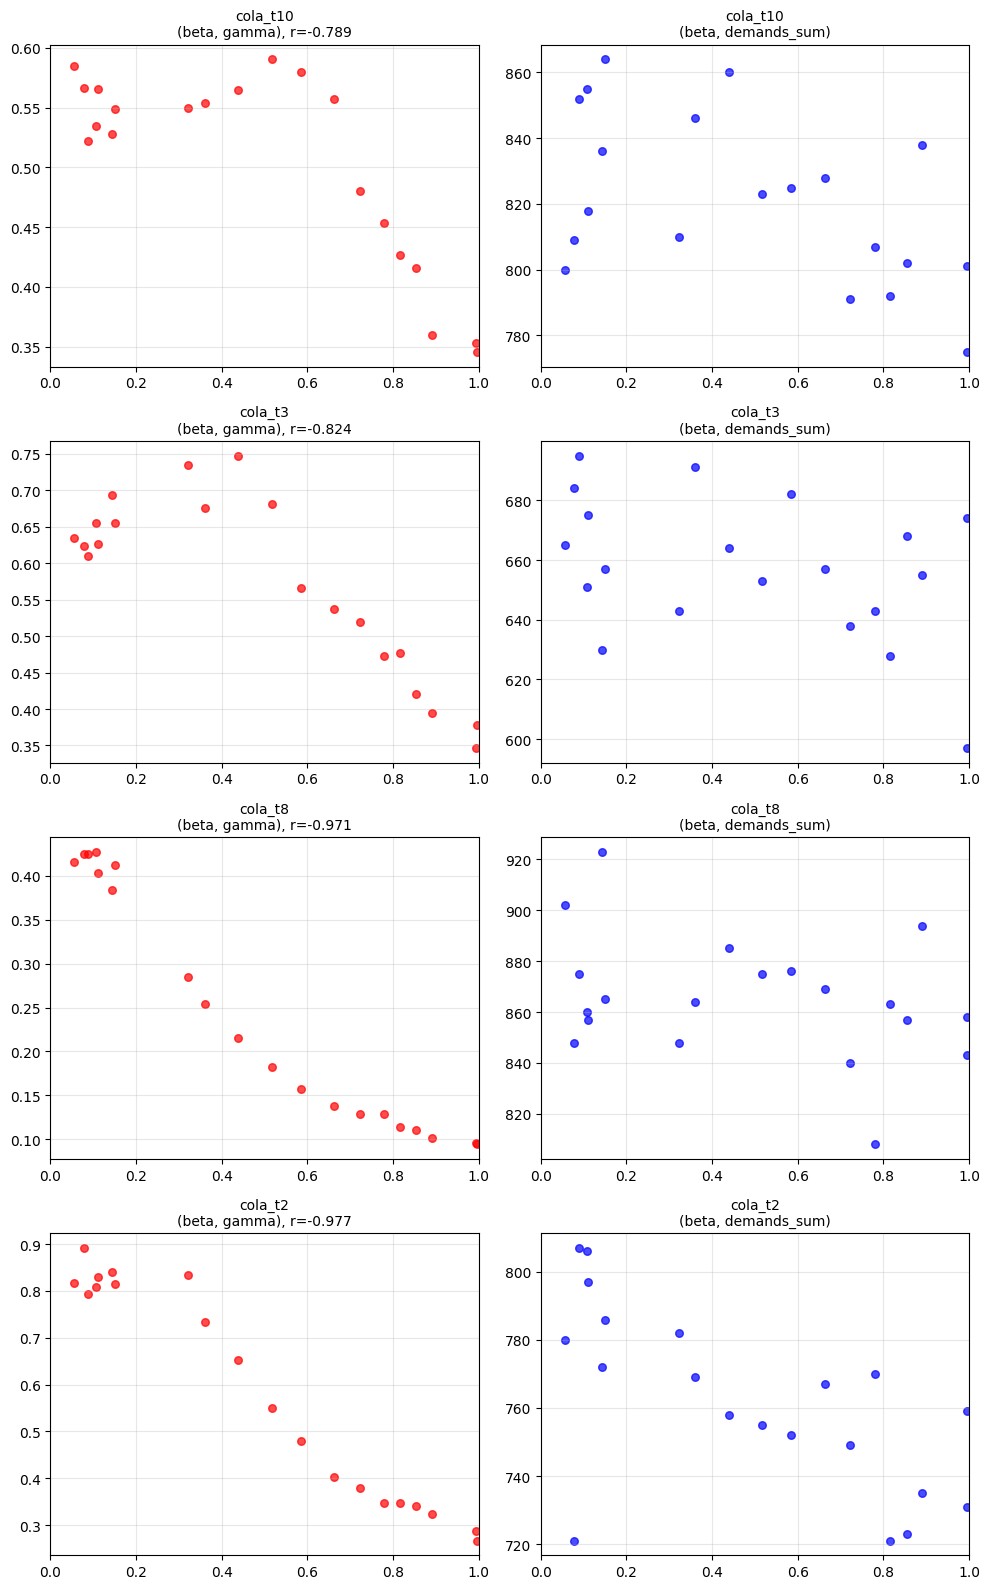

In [49]:
create_comparison_plots(output)

In [50]:
betas_line_sample = np.arange(0.05, 1.00, 0.05)
output_line = []

for name, graph in graphs_for_test.items():
  output_sample = {}
  output_sample['name'] = name
  output_sample['x'], output_sample['y'], output_sample['z'] = [], [], []
  for beta in betas_line_sample:
    graph_gravity = GraphMCF(graph['adj_matrix'])
    graph_size = graph_gravity.n
    median_capacity = np.median([data['weight'] for u, v, data in graph_gravity.graph.edges(data=True) if 'weight' in data])
    gen = GravitationalGenerator(beta=beta, intensity=int(3*median_capacity*graph_size), centrality='pagerank', edge_perc=1/graph_size, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=0.8)
    res = gen.generate(graph_gravity)

    demands_laplacian = compute_laplacian_matrix(graph_gravity.demands_graph)
    sol = solve_throughput(graph_gravity.graph, demands_laplacian)
    gamma = sol.gamma

    demands_sum = sum(data['weight'] for u, v, data in graph_gravity.demands_graph.edges(data=True))

    output_sample['x'].append(beta)
    output_sample['y'].append(float(gamma))
    output_sample['z'].append(int(demands_sum))
  output_line.append(output_sample)

cola_t10 (beta, gamma): Корреляция = -0.7263, p-value = 0.0004 (значим)
cola_t10 (demands_sum): min=784.0000, max=872.0000, range=88.0000, std=24.5667, mean=824.0526
cola_t3 (beta, gamma): Корреляция = -0.8274, p-value = 0.0000 (значим)
cola_t3 (demands_sum): min=620.0000, max=687.0000, range=67.0000, std=19.6127, mean=660.1579
cola_t8 (beta, gamma): Корреляция = -0.9653, p-value = 0.0000 (значим)
cola_t8 (demands_sum): min=831.0000, max=903.0000, range=72.0000, std=17.1510, mean=864.0526
cola_t2 (beta, gamma): Корреляция = -0.9670, p-value = 0.0000 (значим)
cola_t2 (demands_sum): min=719.0000, max=802.0000, range=83.0000, std=22.3685, mean=754.5789


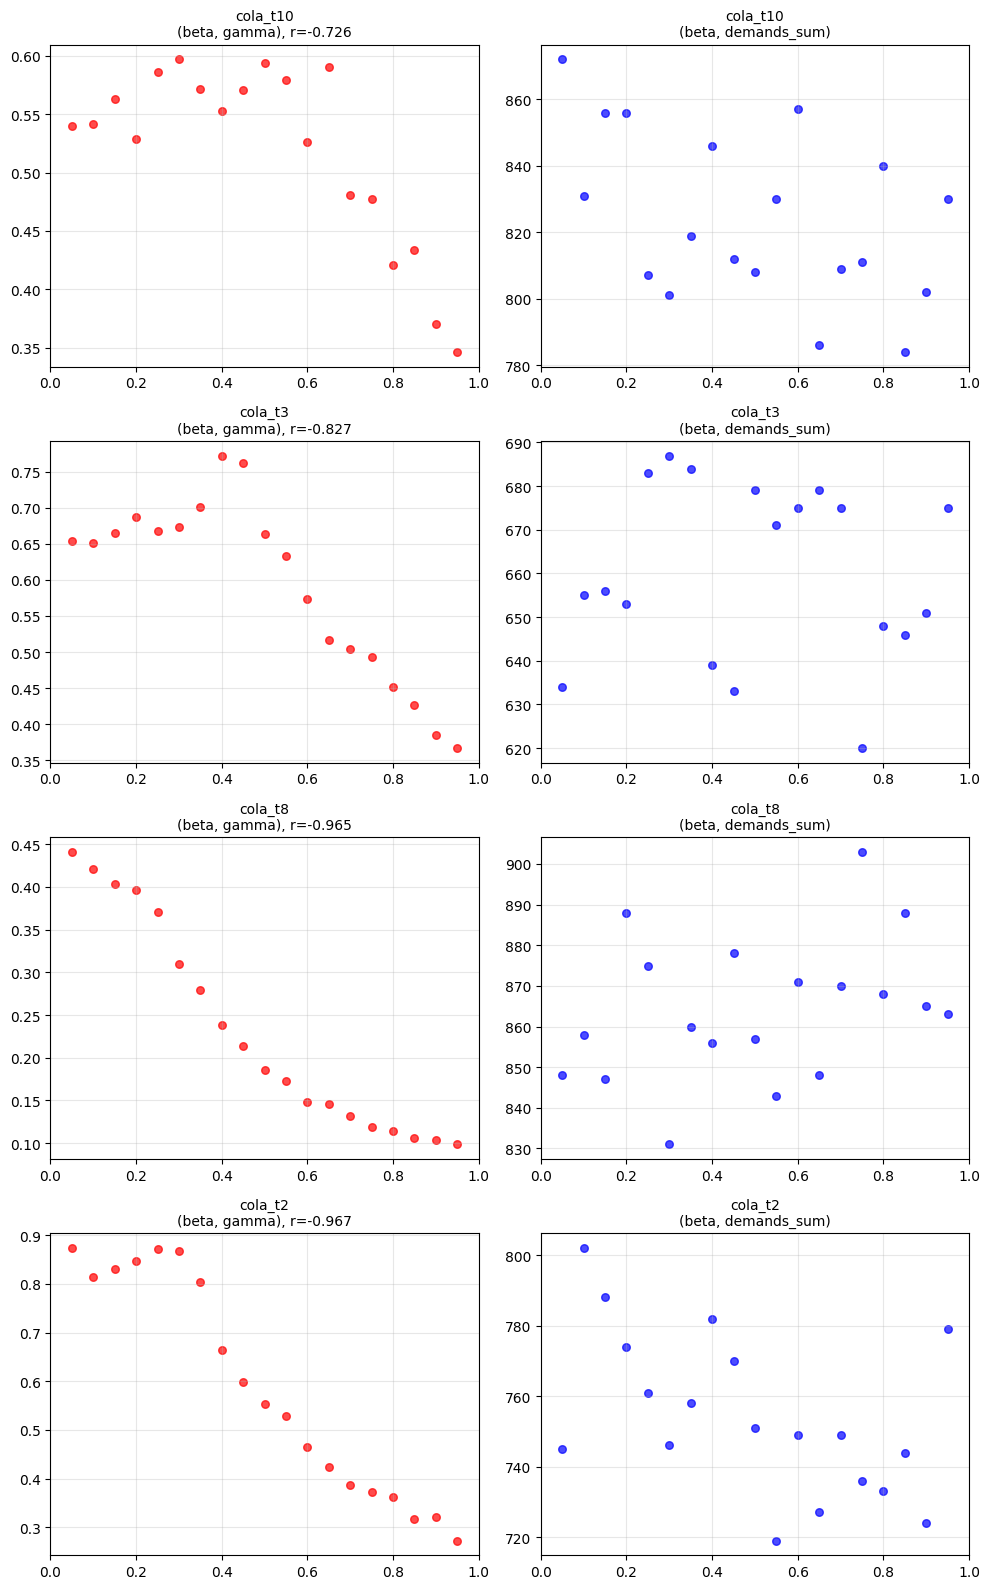

In [51]:
create_comparison_plots(output_line)

In [52]:
clustered_graphs_for_test_names = ['2024_southwest', '2024_north', '2024_south']
clustered_graphs_for_test = get_graphs(path_to_folder, clustered_graphs_for_test_names, True)

/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='N

In [55]:
sample_size = 20
betas_sample = [random.uniform(0, 1) for _ in range(sample_size)]
output_hc = []

for name, graph in clustered_graphs_for_test.items():
  output_sample = {}
  output_sample['name'] = name
  output_sample['x'], output_sample['y'], output_sample['z'] = [], [], []
  for beta in betas_sample:
    graph_gravity = GraphMCF(graph['adj_matrix'])
    graph_size = graph_gravity.n
    median_capacity = np.median([data['weight'] for u, v, data in graph_gravity.graph.edges(data=True) if 'weight' in data])
    gen = GravitationalGenerator(beta=beta, intensity=int(3*median_capacity*graph_size), centrality='pagerank', edge_perc=1/graph_size, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=0.95)
    res = gen.generate(graph_gravity)

    demands_laplacian = compute_laplacian_matrix(graph_gravity.demands_graph)
    sol = solve_throughput(graph_gravity.graph, demands_laplacian)
    gamma = sol.gamma

    demands_sum = sum(data['weight'] for u, v, data in graph_gravity.demands_graph.edges(data=True))

    output_sample['x'].append(beta)
    output_sample['y'].append(float(gamma))
    output_sample['z'].append(int(demands_sum))
  output_hc.append(output_sample)

2024_southwest (beta, gamma): Корреляция = -0.4950, p-value = 0.0265 (значим)
2024_southwest (demands_sum): min=2389.0000, max=2558.0000, range=169.0000, std=34.9944, mean=2442.3000
2024_south (beta, gamma): Корреляция = -0.9280, p-value = 0.0000 (значим)
2024_south (demands_sum): min=2472.0000, max=2629.0000, range=157.0000, std=43.1010, mean=2546.0000
2024_north (beta, gamma): Корреляция = -0.7110, p-value = 0.0004 (значим)
2024_north (demands_sum): min=2481.0000, max=2637.0000, range=156.0000, std=37.0700, mean=2554.2500


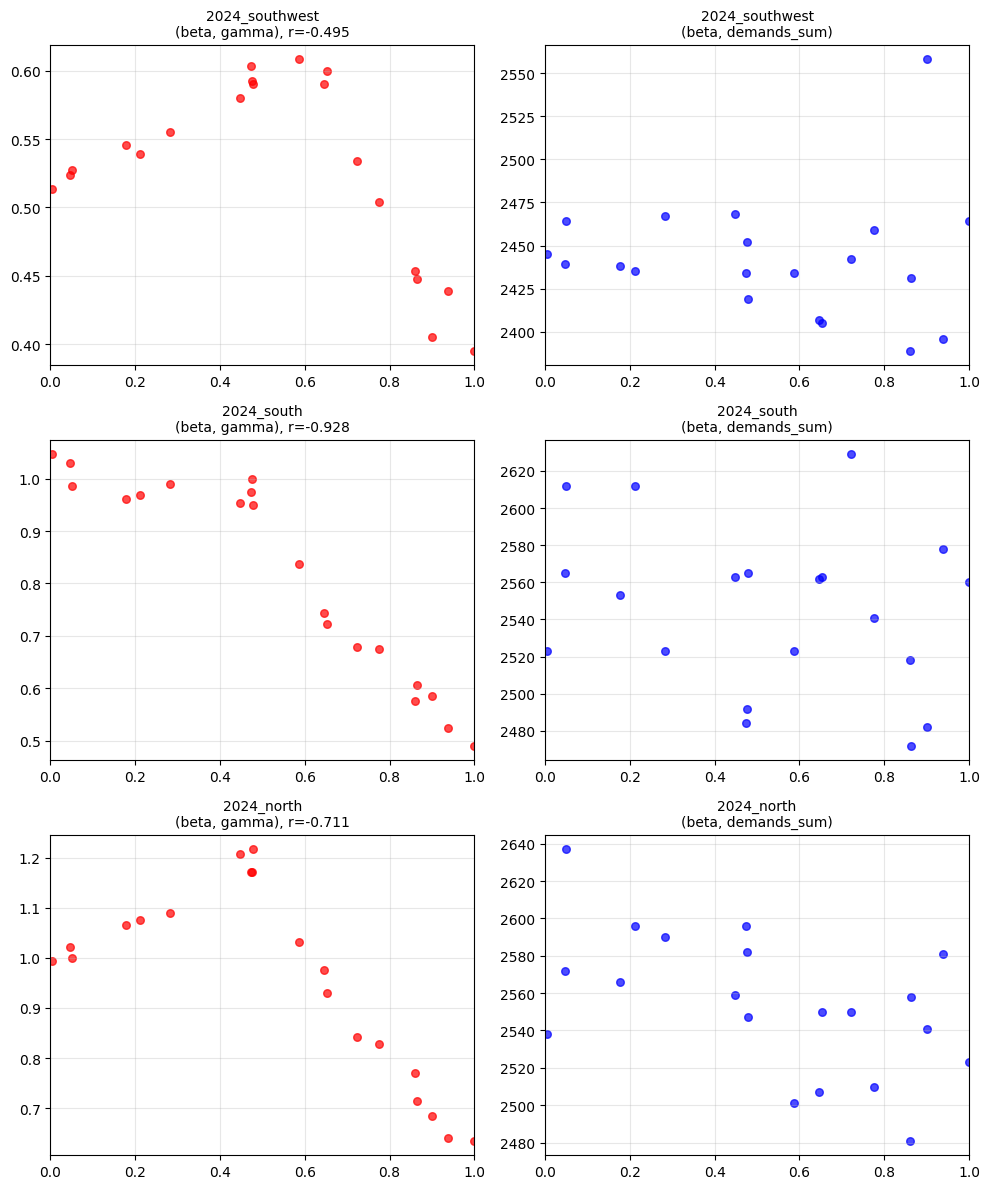

In [56]:
create_comparison_plots(output_hc)

In [57]:
betas_line_sample = np.arange(0.05, 1.00, 0.05)
output_line_hc = []

for name, graph in clustered_graphs_for_test.items():
  output_sample = {}
  output_sample['name'] = name
  output_sample['x'], output_sample['y'], output_sample['z'] = [], [], []
  for beta in betas_line_sample:
    graph_gravity = GraphMCF(graph['adj_matrix'])
    graph_size = graph_gravity.n
    median_capacity = np.median([data['weight'] for u, v, data in graph_gravity.graph.edges(data=True) if 'weight' in data])
    gen = GravitationalGenerator(beta=beta, intensity=int(3*median_capacity*graph_size), centrality='pagerank', edge_perc=1/graph_size, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=0.95)
    res = gen.generate(graph_gravity)

    demands_laplacian = compute_laplacian_matrix(graph_gravity.demands_graph)
    sol = solve_throughput(graph_gravity.graph, demands_laplacian)
    gamma = sol.gamma

    demands_sum = sum(data['weight'] for u, v, data in graph_gravity.demands_graph.edges(data=True))

    output_sample['x'].append(beta)
    output_sample['y'].append(float(gamma))
    output_sample['z'].append(int(demands_sum))
  output_line_hc.append(output_sample)

2024_southwest (beta, gamma): Корреляция = -0.4515, p-value = 0.0523 (не значим)
2024_southwest (demands_sum): min=2323.0000, max=2555.0000, range=232.0000, std=57.9823, mean=2453.0526
2024_south (beta, gamma): Корреляция = -0.9448, p-value = 0.0000 (значим)
2024_south (demands_sum): min=2478.0000, max=2614.0000, range=136.0000, std=35.6561, mean=2549.8947
2024_north (beta, gamma): Корреляция = -0.7476, p-value = 0.0002 (значим)
2024_north (demands_sum): min=2452.0000, max=2632.0000, range=180.0000, std=43.7258, mean=2547.9474


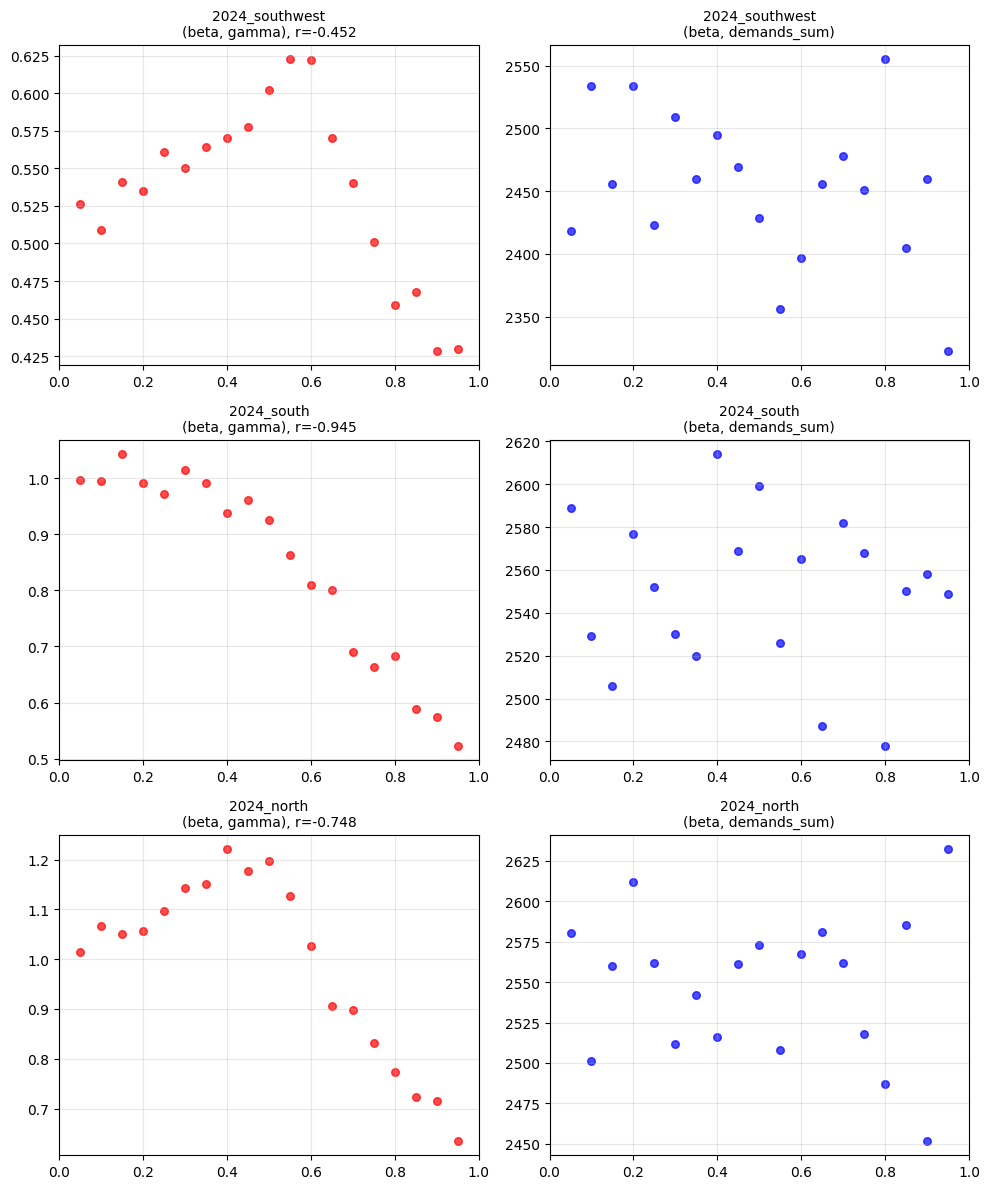

In [58]:
create_comparison_plots(output_line_hc)

In [61]:
graph_for_test_names = ['cola_t10', 'cola_t8']
graph_for_test = get_graphs(path_to_folder, graph_for_test_names, True)

/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='N

In [64]:
import random
import numpy as np
from graphmcf.core import GraphMCF
from graphmcf.demands import GravitationalGenerator
from graphmcf.data import compute_laplacian_matrix

sample_size = 20
betas_sample = [random.uniform(0, 1) for _ in range(sample_size)]
output_cola = []

for name, graph in graph_for_test.items():
  output_sample = {}
  output_sample['name'] = name
  output_sample['x'], output_sample['y'], output_sample['z'] = [], [], []
  for beta in betas_sample:
    graph_gravity = GraphMCF(graph['adj_matrix'])
    graph_size = graph_gravity.n
    median_capacity = np.median([data['weight'] for u, v, data in graph_gravity.graph.edges(data=True) if 'weight' in data])
    gen = GravitationalGenerator(beta=beta, intensity=int(1.5*median_capacity*graph_size), centrality='pagerank', edge_perc=1/graph_size, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=0.8)
    res = gen.generate(graph_gravity)

    demands_laplacian = compute_laplacian_matrix(graph_gravity.demands_graph)
    sol = solve_throughput(graph_gravity.graph, demands_laplacian)
    gamma = sol.gamma

    demands_sum = sum(data['weight'] for u, v, data in graph_gravity.demands_graph.edges(data=True))

    output_sample['x'].append(beta)
    output_sample['y'].append(float(gamma))
    output_sample['z'].append(int(demands_sum))
  output_cola.append(output_sample)

cola_t10 (beta, gamma): Корреляция = -0.7934, p-value = 0.0000 (значим)
cola_t10 (demands_sum): min=377.0000, max=470.0000, range=93.0000, std=21.9392, mean=413.8500
cola_t8 (beta, gamma): Корреляция = -0.9726, p-value = 0.0000 (значим)
cola_t8 (demands_sum): min=409.0000, max=458.0000, range=49.0000, std=13.9049, mean=434.4500


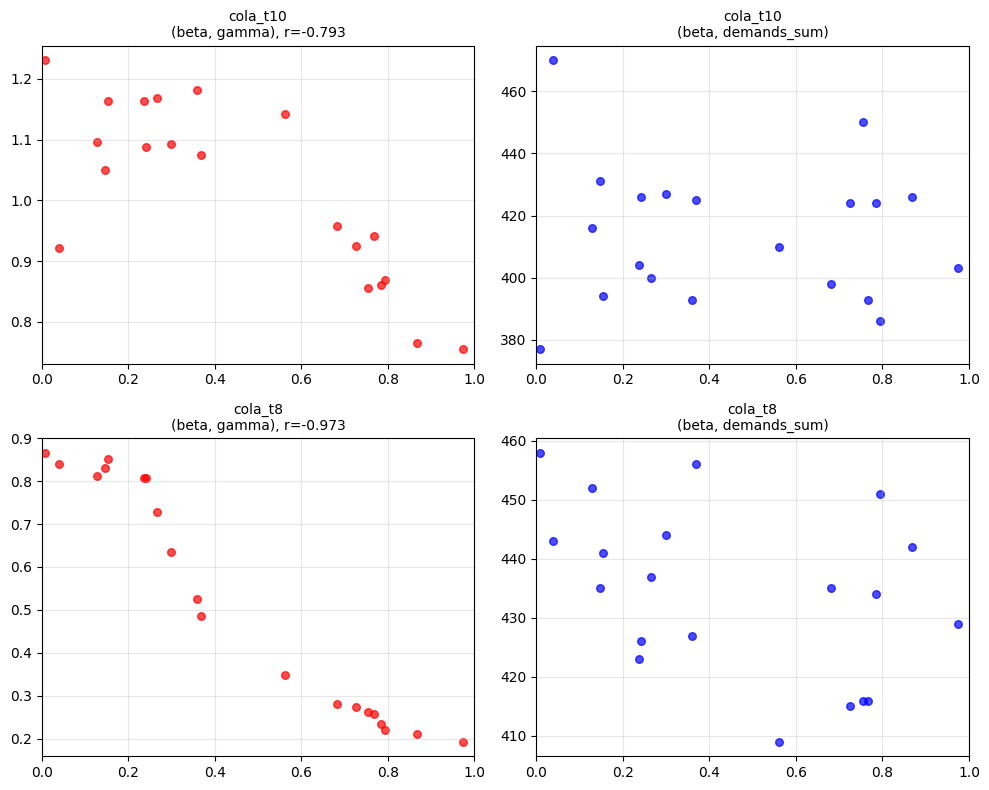

In [65]:
create_comparison_plots(output_cola)

In [66]:
import random
import numpy as np
from graphmcf.core import GraphMCF
from graphmcf.demands import GravitationalGenerator
from graphmcf.data import compute_laplacian_matrix

sample_size = 20
betas_sample = np.arange(0.05, 1.00, 0.05)
output_line_cola = []

for name, graph in graph_for_test.items():
  output_sample = {}
  output_sample['name'] = name
  output_sample['x'], output_sample['y'], output_sample['z'] = [], [], []
  for beta in betas_sample:
    graph_gravity = GraphMCF(graph['adj_matrix'])
    graph_size = graph_gravity.n
    median_capacity = np.median([data['weight'] for u, v, data in graph_gravity.graph.edges(data=True) if 'weight' in data])
    gen = GravitationalGenerator(beta=beta, intensity=int(1.5*median_capacity*graph_size), centrality='pagerank', edge_perc=1/graph_size, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=0.8)
    res = gen.generate(graph_gravity)

    demands_laplacian = compute_laplacian_matrix(graph_gravity.demands_graph)
    sol = solve_throughput(graph_gravity.graph, demands_laplacian)
    gamma = sol.gamma

    demands_sum = sum(data['weight'] for u, v, data in graph_gravity.demands_graph.edges(data=True))

    output_sample['x'].append(beta)
    output_sample['y'].append(float(gamma))
    output_sample['z'].append(int(demands_sum))
  output_line_cola.append(output_sample)

cola_t10 (beta, gamma): Корреляция = -0.6197, p-value = 0.0047 (значим)
cola_t10 (demands_sum): min=386.0000, max=447.0000, range=61.0000, std=17.2146, mean=413.8421
cola_t8 (beta, gamma): Корреляция = -0.9637, p-value = 0.0000 (значим)
cola_t8 (demands_sum): min=403.0000, max=486.0000, range=83.0000, std=17.5886, mean=429.8947


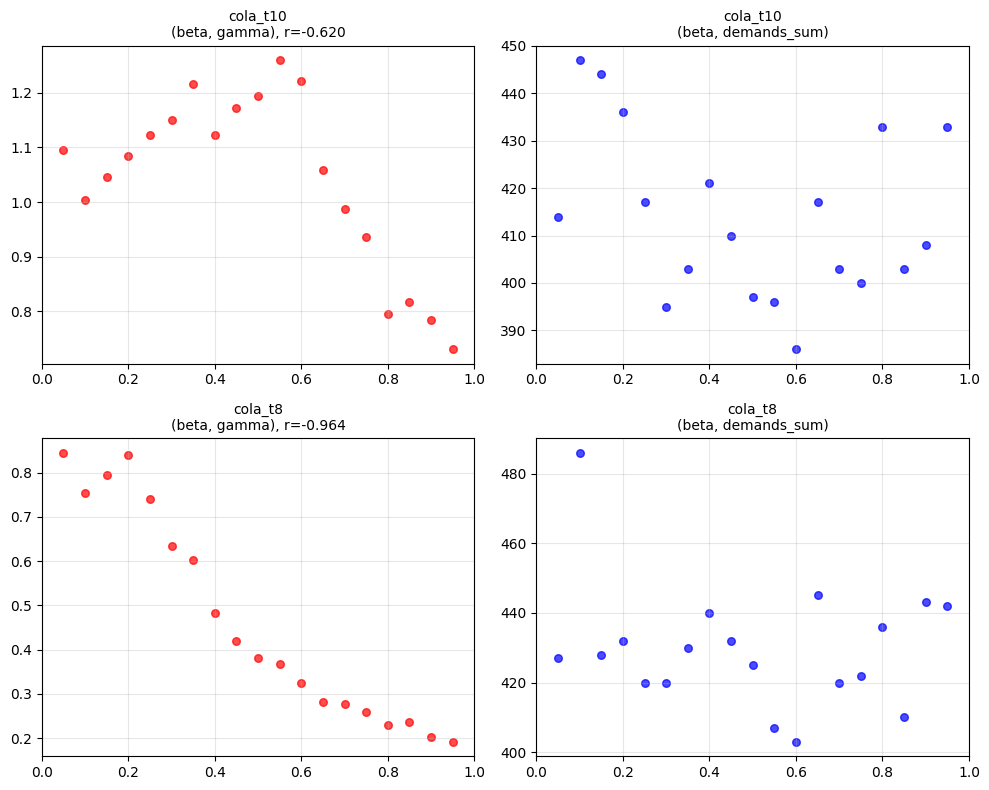

In [67]:
create_comparison_plots(output_line_cola)